In [11]:
import pycaret
from pycaret.classification import *

import pandas as pd
import lightgbm as lgbm
import catboost as cb
import numpy as np
from datetime import date

import pandas_profiling as pp

import lifetimes

import numpy as np
import sklearn

from sklearn.model_selection import train_test_split


pd.options.mode.chained_assignment = None
import math

## 고객테이블 Visualization

In [ ]:
cust = pd.read_csv('P:/final_all_customer_table.csv')

In [13]:
cust['bin_count'] = cust['total_buys'].apply(lambda x: 0 if x<1 else 1)

In [14]:
cust

,insd_usermbr_no,mno_cd,first_prchs_dt,last_prchs_dt,sex_clsf_cd,age_cd,total_prchs_cnt,weekend_prchs_cnt,total_payment_amt,total_cpt_amt,...,wly_prchs_amt_min,wly_prchs_amt_mean,frequency,recency,T,total_buys,dt_step_min,dt_step_max,dt_step_mean,bin_count
0,IF14210296502009062300092258,US001201,2020-03-29,2020-06-29,M,042,12,3,93630,5670,...,10100,23407.500000,3.0,92.0,124.0,0.0,15.0,45.0,23.0,0
1,IF142158893220090701150416,US001201,2020-04-11,2020-06-24,F,040,285,127,502,10968,...,0,41.833333,56.0,74.0,111.0,0.0,1.0,6.0,1.3,0
2,IF142158896620090701190525,US001201,2020-07-06,2020-07-06,M,046,1,0,8860,1500,...,8860,8860.000000,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0
3,IF142158935420090720101940,US001201,2020-03-26,2020-05-31,F,039,25,17,6100,200,...,600,1525.000000,3.0,66.0,127.0,0.0,14.0,36.0,16.5,0
4,IF1423000039820090904101650,US001201,2020-02-03,2020-07-31,M,045,155,15,374760,38720,...,0,26768.571429,24.0,179.0,179.0,2.0,1.0,40.0,7.2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150038,US2020073119334183757417968,US001201,2020-07-31,2020-07-31,F,032,10,0,2910,3090,...,2910,2910.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
150039,US2020073120311703057418673,US001206,2020-07-31,2020-07-31,Z,ZZZ,1,0,500,400,...,500,500.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
150040,US2020073121374433957419409,US001203,2020-07-31,2020-07-31,F,044,49,0,4700,200,...,4700,4700.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
150041,US2020073121424175457419483,US001201,2020-07-31,2020-07-31,Z,ZZZ,1,0,0,100,...,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [15]:
# cust = cust.drop(['total_buys', "insd_usermbr_no", "prep_dtl_category"], axis = 1)

In [16]:
cust = cust[cust.sex_clsf_cd  != 'Z']

cust = cust[cust.age_cd  != 'ZZZ']

In [17]:
def caltime(x):
    if x in ['02 ~03', '03 ~04' , '04 ~05', '05~06']:
        return 1
    if x in ['06 ~07','07 ~08','08 ~09''09 ~10']:
        return 2
    if x in ['10 ~11','11 ~12','12 ~13''13 ~14']:
        return 3
    if x in ['14 ~15','15 ~16','16 ~17','17 ~18']:
        return 4
    if x in ['18 ~19','19 ~20','20 ~21','22 ~23']:
        return 5
    else:
        return 6

In [18]:
cust['age_cd'] = cust['age_cd'].astype(float)

In [19]:
cust1 = cust

In [20]:
def age1(x):
    if x == -1: 
        return -1
    else:
        return x - x%10

In [21]:
def age(x):
    return round(x,-1)

In [22]:
cust['age_cd'] = pd.DataFrame(cust['age_cd'].apply(lambda x: age(x)))

In [23]:
cust1['age_cd'] = pd.DataFrame(cust1['age_cd'].apply(lambda x: age1(x)))

In [24]:
cust.head()

,insd_usermbr_no,mno_cd,first_prchs_dt,last_prchs_dt,sex_clsf_cd,age_cd,total_prchs_cnt,weekend_prchs_cnt,total_payment_amt,total_cpt_amt,...,wly_prchs_amt_min,wly_prchs_amt_mean,frequency,recency,T,total_buys,dt_step_min,dt_step_max,dt_step_mean,bin_count
0,IF14210296502009062300092258,US001201,2020-03-29,2020-06-29,M,40.0,12,3,93630,5670,...,10100,23407.500000,3.0,92.0,124.0,0.0,15.0,45.0,23.0,0
1,IF142158893220090701150416,US001201,2020-04-11,2020-06-24,F,40.0,285,127,502,10968,...,0,41.833333,56.0,74.0,111.0,0.0,1.0,6.0,1.3,0
2,IF142158896620090701190525,US001201,2020-07-06,2020-07-06,M,50.0,1,0,8860,1500,...,8860,8860.000000,0.0,0.0,25.0,0.0,0.0,0.0,0.0,0
3,IF142158935420090720101940,US001201,2020-03-26,2020-05-31,F,40.0,25,17,6100,200,...,600,1525.000000,3.0,66.0,127.0,0.0,14.0,36.0,16.5,0
4,IF1423000039820090904101650,US001201,2020-02-03,2020-07-31,M,40.0,155,15,374760,38720,...,0,26768.571429,24.0,179.0,179.0,2.0,1.0,40.0,7.2,1


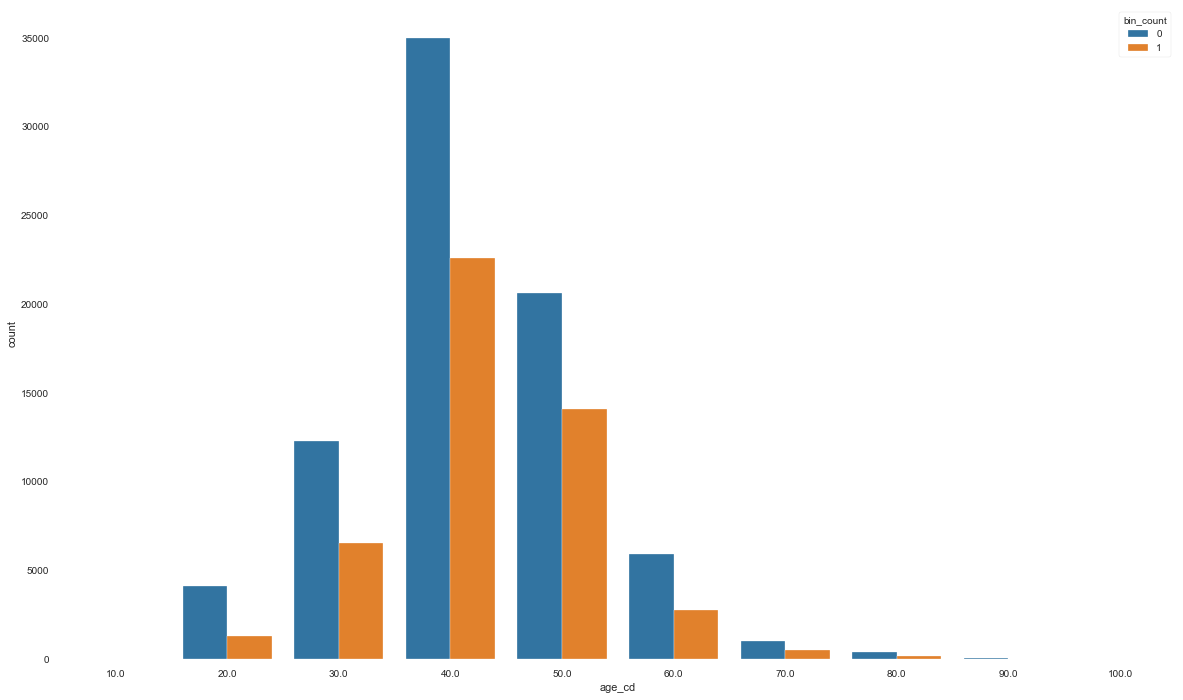

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns
a,b = plt.subplots(1,1,figsize = (20,12))
sns.countplot(cust['age_cd'],hue = cust['bin_count'])

In [26]:
cust2 =cust[ (cust['dt_step_max']>= 10)&  (cust['dt_step_max']<= 70)]

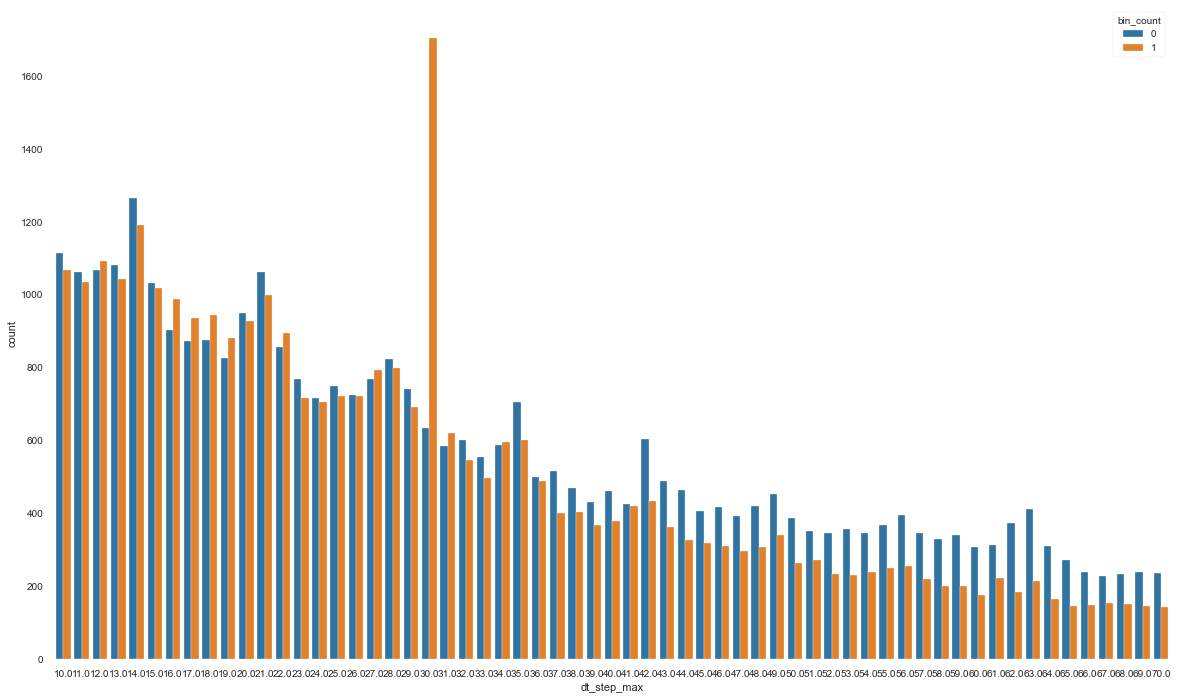

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns
a,b = plt.subplots(1,1,figsize = (20,12))
sns.countplot(cust2['dt_step_max'],hue = cust['bin_count'])

In [28]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# a,b = plt.subplots(1,1,figsize = (20,12))
# sns.countplot(cust1['age_cd'],hue = cust1['total_buys'])

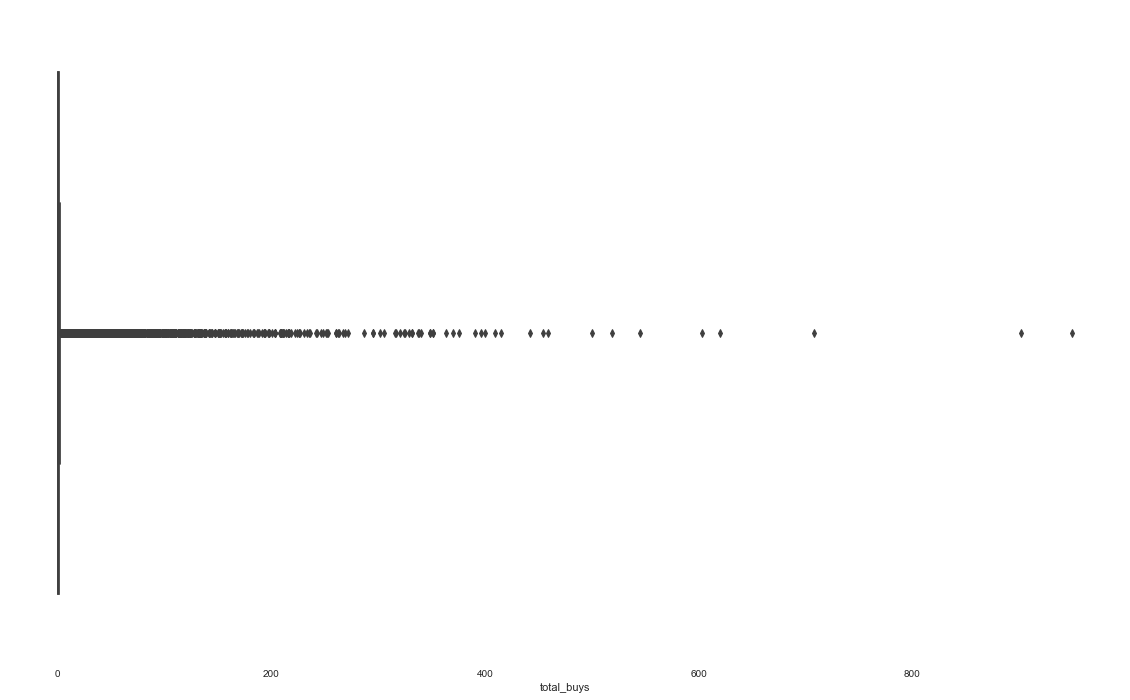

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,12))
sns.boxplot(cust['total_buys'])

In [30]:
# cust2 =cust[ (cust['total_buys']< 100) & (cust['total_buys'] > 2) ]

In [31]:
cust2['total_buys'] = np.exp(cust['total_buys'])

C:\ProgramData\Anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: overflow encountered in exp
  result = getattr(ufunc, method)(*inputs, **kwargs)


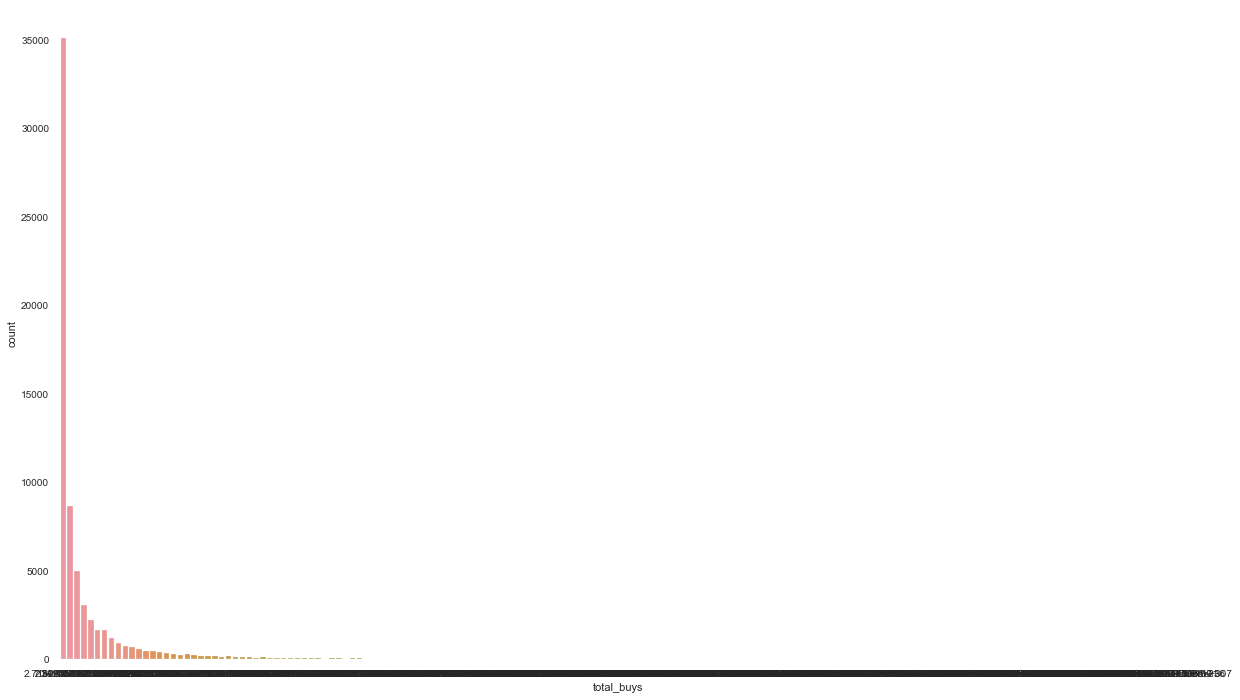

In [32]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize = (20,12))
sns.countplot(cust2['total_buys'])

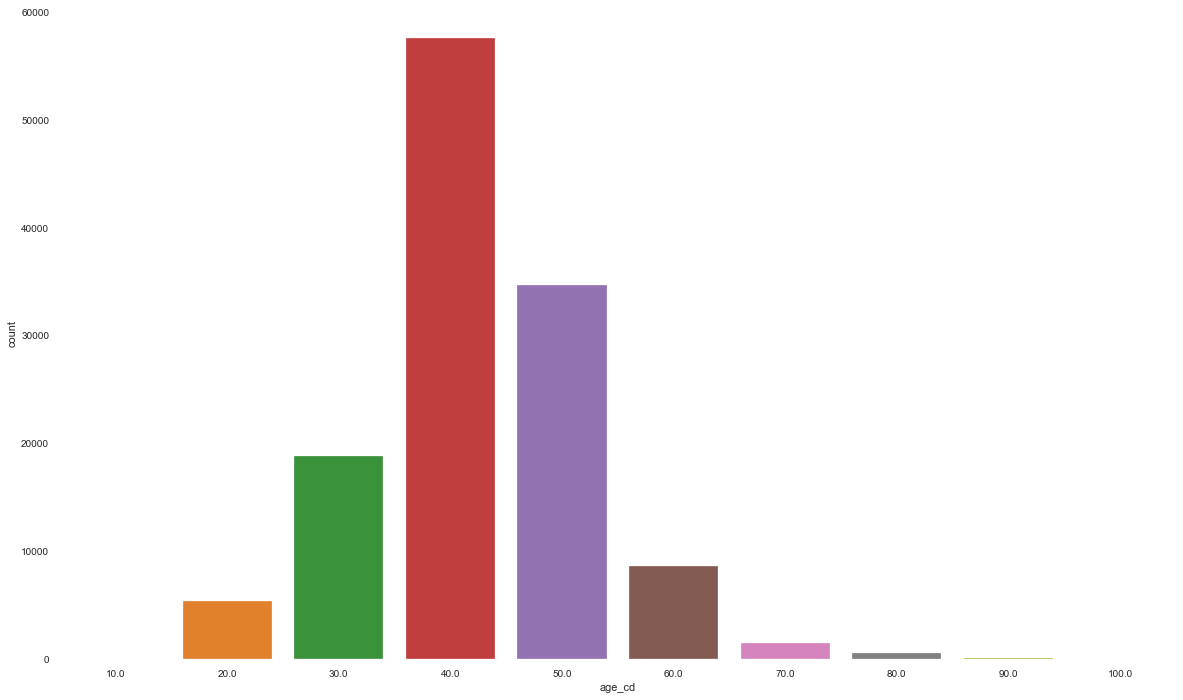

In [33]:
import matplotlib.pyplot as plt
import seaborn as sns
a,b = plt.subplots(1,1,figsize = (20,12))
sns.countplot(cust1['age_cd'])

## 구매테이블 Visualization

In [35]:
prchs_f = pd.read_csv('P:/final_prchs_data.csv')

In [36]:
prchs_f

,prchs_id,prod_id,partition_dt,insd_usermbr_no,prod_amt,sex_clsf_cd,age_cd,category_nm,dtl_category_nm,prchs_tm_clsf_nm,mno_cd,cust_payment_amt,sett_target_cpn_amt,pay_mtd_cnt
0,20013123592010721507,H018480692,20200201,IF1423177586220101006224941,3600,F,042,eBook,로맨스,00 ~ 01,US001201,3240,360,3
1,20013123593010931584,H038835416,20200201,US2018070914480184346187029,900,M,037,eBook,무협,00 ~ 01,US001201,810,90,2
2,20013123593510331626,H031234584,20200201,US2018092811402674047654410,900,Z,ZZZ,eBook,판타지,00 ~ 01,US001201,810,90,2
3,20013123595120417183,H038724908,20200201,US2018033113065860244558735,3150,F,051,eBook,로맨스,00 ~ 01,US001202,3150,0,1
4,20013123595221217187,H035730852,20200201,US2019112415415699154280728,200,F,043,웹툰,순정,00 ~ 01,US001202,180,20,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
34246915,20073123595710341883,H036432165,20200731,IW1425165373520130326161430,900,M,055,eBook,무협,23 ~ 24,US001201,0,900,1
34246916,20073123595711341887,H039065277,20200731,US2018021812545532143805173,100,F,044,eBook,로맨스,23 ~ 24,US001201,100,0,1
34246917,20073123595711521890,H039535654,20200731,IW1426246252320131022221027,300,F,049,웹툰,BL,23 ~ 24,US001201,0,300,1
34246918,20073123595810242233,H039578892,20200731,IF1423206725420101129205051,100,F,037,eBook,판타지,23 ~ 24,US001201,0,0,1


In [37]:
def age1(x):
    if x == -1: 
        return -1
    else:
        return x - x%10

# prchs_f['age_cd'] = prchs_f['age_cd'].astype(float)

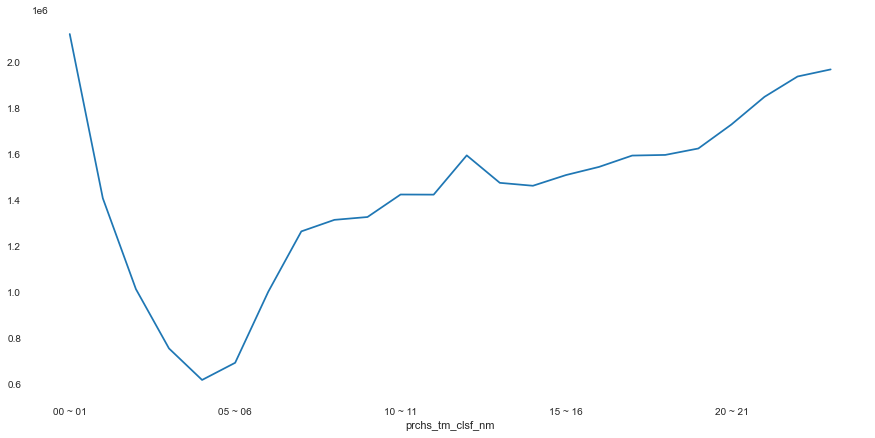

In [38]:
import matplotlib.pyplot as plt
import seaborn as sns
fig, ax = plt.subplots(figsize=(15,7))
prchs_f.groupby(['prchs_tm_clsf_nm'])['prchs_id'].count().plot(ax=ax)

In [40]:
a['count'] =pd.DataFrame(prchs_f.groupby(['prchs_tm_clsf_nm'])['prchs_id'].count())

TypeError: 'Figure' object does not support item assignment

In [ ]:
# import matplotlib.pyplot as plt
# import seaborn as sns
# a = plt.subplots(1,1,figsize = (20,12))
# sns.countplot(prchs_f['prchs_tm_clsf_nm'],a['count'])

# cust['bin_count'] = cust['total_buys'].apply(lambda x: 0 if x<1 else 1)

In [41]:
prchs_f.groupby(['sex_clsf_cd'])['cust_payment_amt'].sum()

sex_clsf_cd
F    4921319756
M    4891223622
Z     592905925
Name: cust_payment_amt, dtype: int64

In [42]:
prchs_f['sex_clsf_cd'].value_counts()

M    20557928
F    11267565
Z     2421427
Name: sex_clsf_cd, dtype: int64

In [43]:
prchs_f.groupby(['category_nm'])['cust_payment_amt'].sum()

category_nm
eBook    6344376318
만화        649055358
오디오북        5297058
웹소설        20165026
웹툰        888290258
정액제      2498265285
Name: cust_payment_amt, dtype: int64

In [44]:
prchs_f.groupby(['sex_clsf_cd', 'category_nm'])['cust_payment_amt'].sum()

sex_clsf_cd  category_nm
F            eBook          2565754722
             만화              414387579
             오디오북              1474350
             웹소설              12423052
             웹툰              610472749
             정액제            1316807304
M            eBook          3325662661
             만화              215298882
             오디오북              2903855
             웹소설               7511518
             웹툰              263199786
             정액제            1076646920
Z            eBook           452958935
             만화               19368897
             오디오북               918853
             웹소설                230456
             웹툰               14617723
             정액제             104811061
Name: cust_payment_amt, dtype: int64

In [45]:
prchs_f.groupby(['sex_clsf_cd', 'category_nm'])['cust_payment_amt'].count()

sex_clsf_cd  category_nm
F            eBook           6633567
             만화              1280729
             오디오북                436
             웹소설              261725
             웹툰              2826761
             정액제              264347
M            eBook          18553743
             만화               907877
             오디오북                721
             웹소설              110889
             웹툰               853835
             정액제              130863
Z            eBook           2175239
             만화                79396
             오디오북                305
             웹소설                6907
             웹툰               145871
             정액제               13709
Name: cust_payment_amt, dtype: int64